In [1]:
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

In [2]:
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

路径中，ImageSets/Segmentation 是训练数据和验证数据的文本文件（告诉你哪些图片是用来训练或者验证的，以图片名称命名），JPEGImages 中包含所有图像，SegmentationClass 是标签，标签也是以图像方式存储，且标签中颜色相同的像素同属一个类别（以颜色-RGB 区分类别，每个颜色代表一种类别），SegmentationObject 应该是实例分割的标签

In [33]:
def read_voc_images(voc_dir, is_train=True):
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation', 
                            'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split() # images 是一个列表，包含所有图片名，好用
    images = images[:8] # 演示用，实际要删掉
    features, labels = [] ,[]
    for fname in images: # 即要每轮下标，又要内容
        features.append(torchvision.io.read_image(os.path.join(voc_dir, 'JPEGImages', fname + '.jpg')))
        """ 这里 read_image() 加上 RGB 通道模式显示颜色"""
        labels.append(torchvision.io.read_image(os.path.join(voc_dir, 'SegmentationClass', fname + '.png'), mode))
    return features, labels

In [34]:
train_features, train_labels = read_voc_images(voc_dir)

列举一些图片的 feature 和 label 对应情况

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

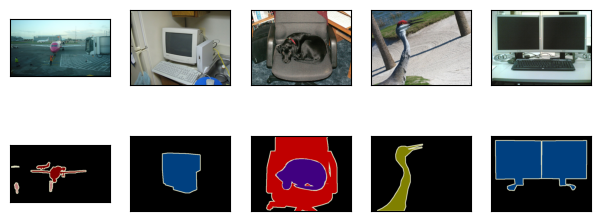

In [51]:
n = 5
imgs = train_features[:n] + train_labels[:n]
imgs = [img.permute(1,2,0) for img in imgs] # permute是转换维度，(1,2,0)就是把通道数变到第三维
d2l.show_images(imgs, 2, n)

以下是 RGB（颜色）和类别对应情况

In [32]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

`voc_colormap2label` 函数构建一个 256 * 256 * 256 区域，将 VOC_COLORMAP 中每个颜色在区域中对应位置标注出类别

In [82]:
def voc_colormap2label():
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long) # 256 * 256 * 256 区域，每个位置都是代表颜色
    for i, colormap in enumerate(VOC_COLORMAP):
        """ 找到区域中对应 RGB 的位置，并把这个位置设置成相应的类别 """
        colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

`voc_label_indices` 函数在 `voc_colormap2label` 中找到输入图片的每个像素代表的类别

In [88]:
def voc_label_indices(colormap, colormap2label):
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    """ 得到每个像素对应的 RGB 在 256**3 区域内的下标 """
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256) + colormap[:, :, 2]
    """ 由于事先在 256**3 区域中标注每个 RGB 的位置和对应的类别，colormap2label[idx] 获得每个像素对应的类别，如 RGB = X, 带入得到 X 的类型 """
    return colormap2label[idx]

In [91]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

### 预处理数据

不能缩放图像，缩放后映射的像素不准确，只能随机裁剪，`voc_rand_crop` 函数实现随机裁剪

In [124]:
def voc_rand_crop(feature, label, height, width):
    rect = torchvision.transforms.RandomCrop.get_params(feature, (height, width)) # 拿到随机裁剪的参数
    feature = torchvision.transforms.functional.crop(feature, *rect) # 拿随机裁剪的参数固定去裁剪特征和标签图片
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

10


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

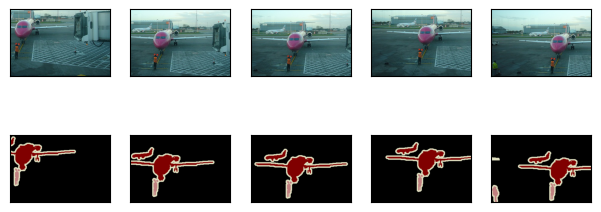

In [127]:
imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
print(len(imgs))
imgs = [img.permute(1, 2, 0) for img in imgs]
""" 由于图像是一张特征一张标签，[::2] 从零开始步长为 2，取0, 2, 4...，[1::2] 取 1, 3, 5... """
d2l.show_images(imgs[::2] + imgs[1::2], 2, n)

### 自定义语义分割数据集

`VOCSegDataset` 类实现了对输入的标准化并输出，其中过滤一些尺寸小于规定的裁剪输出的图片

In [134]:
class VOCSegDataset(torch.utils.data.Dataset):
    def __init__(self, is_train, crop_size, voc_dir):
        self.tranform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature) for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.tranform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if(img.shape[1] >= self.crop_size[0] and img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx], *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

In [135]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 7 examples
read 7 examples


In [137]:
batch_size = 5
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True, drop_last=True)

for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)

torch.Size([5, 3, 320, 480])
torch.Size([5, 320, 480])


### 整合

In [138]:
def load_data_voc(batch_size, crop_size):
    voc_dir = d2l.download_extract('voc2012', os.path.join('VOCdevkit', 'VOC2012'))
    train_iter = torch.utils.data.DataLoader(VOCSegDataset(True, crop_size, voc_dir), batch_size, shuffle=True, drop_last=True)
    test_iter = torch.utils.data.DataLoader(VOCSegDataset(False, crop_size, voc_dir), batch_size, drop_last=True)
    return train_iter, test_iter

### 总结

1. 首先裁剪输入的特征和标签图
2. 将像素颜色对应类型进行映射（2 个函数很高级）
3. 标准化并过滤小尺寸图片后就可以输出